<a href="https://colab.research.google.com/github/SethMinor/WSINDy-for-Python/blob/main/Weak_SINDy_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###A Step-by-Step Python Implementation of "**Weak SINDy for PDEs**"
#####Based on the [JCP paper by **D. A. Messenger**, **D. M. Bortz** 2021](https://www.sciencedirect.com/science/article/pii/S0021999121004204). <br> See authors' original [MatLab code repository](https://github.com/MathBioCU/WSINDy_PDE).
#####Python code by Seth Minor, 2024.
---

This notebook is an illustration of the WSINDy algorithm being applied to data obtained from the $(1+1)$-dimensional Kuramoto-Sivashinksy (KS) equation, an example given in the "Weak SINDy for PDEs" paper (referenced above).
\
\
The example `KS.mat` dataset (1.3 MB) can be downloaded from the offical [GitHub repository](https://github.com/MathBioCU/WSINDy_PDE/blob/master/datasets/KS.mat). To export the KS dataset into a Python-readable csv file, export `KS.mat` as `KS.txt` in MatLab using the `'format long fixed decimal'` option.

#### Configure File Paths

Change the working directory to the Google Drive folder `/content/drive/My Drive/WSINDy`

In [1]:
# Optionally, create the desired folder
#!mkdir -p "/content/drive/My Drive/WSINDy"

# Access your Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Change directories
%cd /content/drive/My Drive/WSINDy

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/WSINDy


#### Import Empirical Data

Libraries used:
- `PyTorch` for speedy wrangling of large tensors.

- `NumPy` for handling of smaller tensors [(see `torch` to `numpy` bridge)](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#bridge-to-np-label).

- `Pandas` for importing data.

- `Matplotlib` for plotting.

- `SymPy` for fast calculation of symbolic derivatives.

- `SciPy` for fast (FFT-based) convolutions.

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sp
import scipy

# File path for empirical dataset
file_path = '/content/drive/My Drive/WSINDy'
data_path = file_path + '/KS.txt'

# Read in data
U = (pd.read_csv(data_path, header=None)).values

# Convert to torch tensor
U = torch.tensor(U)

print(f"Imported tensor with shape {U.shape}:\n{U}")

Imported tensor with shape torch.Size([256, 301]):
tensor([[1.0242, 0.9953, 0.9667,  ..., 1.2247, 1.3147, 1.4205],
        [1.0478, 1.0191, 0.9906,  ..., 1.5392, 1.5826, 1.6263],
        [1.0707, 1.0424, 1.0140,  ..., 1.7240, 1.6913, 1.6393],
        ...,
        [0.9498, 0.9207, 0.8925,  ..., 0.2924, 0.3843, 0.5021],
        [0.9752, 0.9460, 0.9176,  ..., 0.5460, 0.6536, 0.7891],
        [1.0000, 0.9709, 0.9423,  ..., 0.8708, 0.9800, 1.1142]],
       dtype=torch.float64)


Optionally, add [artificial (i.i.d.) noise](https://pytorch.org/docs/stable/generated/torch.normal.html) $\epsilon \sim \mathcal{N}(0,\sigma^2$) to the data.



In [3]:
# Noise level
sigma_NR = 0.1;

# RMS norm of empirical data
U_rms = (torch.sqrt(torch.mean(U**2))).item();

# Desired standard deviation
sigma = sigma_NR * U_rms

# Generate N(0,sigma^2) noise
epsilon = torch.normal(mean=0, std=sigma, size=U.shape, dtype=U.dtype)

# Add noise to data
U = U + epsilon

Create appropriately-scaled space-time lattice $(x,t) \in \mathcal{X}$.

In [4]:
# Spatial coordinate
Lx = 32*np.pi
dx = Lx/(U.shape[0])
x = torch.arange(dx, Lx+dx, dx, dtype=U.dtype)

# Time coordinate
T = 150
dt = T/(U.shape[1]-1)
t = torch.arange(0, T+dt, dt, dtype=U.dtype)

# Mesh grid
X_mesh, T_mesh = torch.meshgrid(x, t, indexing='ij')

Visualize empirical dataset.

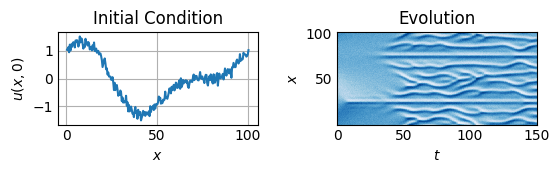

In [32]:
# Plot styling
plt.style.use('_mpl-gallery')
plt.rcParams['figure.figsize'] = [6, 2]
fig, ax = plt.subplots(1,2)
fig.tight_layout(pad = 3.0)

# Find initial condition
IC = U[:,1]

# Plot initial condition
ax[0].plot(x, IC)
ax[0].set_title('Initial Condition')
ax[0].set_xlabel('$x$')
ax[0].set_ylabel('$u(x,0)$')

# Plot space-time evolution
ax[1].pcolormesh(T_mesh, X_mesh, U)
ax[1].set_title('Evolution')
ax[1].set_xlabel('$t$')
ax[1].set_ylabel('$x$')

# Render plot
plt.show()

#### Specify Hyperparameters

The optimal weights $w^{\star}$ and threshold $\lambda^{\star}$ are computed via
\
\
$\quad (w^{\star}, \lambda^{\star})=$ `WSINDy`$\big(\{f_j\}, \ \alpha, \ m, \ s, \ \boldsymbol{\lambda}, \ \tau; \ U, \mathcal{X} \big)$,
\
\
where the hyperparameters are specified by: \begin{align*}
  \\
  \begin{cases}
    \{f_j\} = \text{function library}
    \\
    \alpha = \text{derivative library}
    \\
    m = \text{supp}(\psi_k)
    \\
    s = \text{subsampling rate}
    \\
    \boldsymbol{\lambda} = \text{candidate thresholds}
    \\
    \tau = \text{decay rate of $\psi_k$}
    \\
    U = \text{empirical data}
    \\
    \mathcal{X} = \text{discretized lattice} \ .
  \end{cases}
\end{align*}

In [6]:
# Function library
# Monomial powers
fj_poly = (0, 1, 2, 3, 4, 5, 6)
# (freq, phase) pairs
fj_trig = ()
# Compile library
fj = fj_poly + fj_trig

# Derivative library
lhs = ((0,1),) # evolution operator
rhs = ((0,0), (1,0), (2,0), (3,0),
                (4,0), (5,0), (6,0))
alpha = lhs + rhs

# Test fcn support radius
(mx, mt) = (23,22)

# Query point subsampling rate
(sx, st) = (5,6)

# Candidate thresholds
my_lambda = 1E-4

# Decay rate
tau = 1E-10
#tau_hat = 2

# Known test fcn degrees
(px, pt) = (10, 10)

# Known rescaling values
#(yu, yx, yt) = (0.26, 0.74, 0.091)
#(yu, yx, yt) = (0.4563, 0.74, 0.091)
(yu, yx, yt) = (0.52, 0.74, 0.091)

In [7]:
# What type of function is the jth candidate basis fcn?
fj_names = ['fj_poly']*len(fj_poly) + ['fj_trig']*len(fj_trig)

# What is the ith differential operator?
# (Formats D^i derivatives as a list of strings)
def derivative_names(alpha):
    alpha_names = []
    for elem in alpha:
        x_count, t_count = elem
        if x_count == 0 and t_count == 0:
            alpha_names.append('')
        else:
            alpha_names.append('_' + 't'*t_count + 'x'*x_count)
    return alpha_names

# Derivative names (e.g., '_t','_x' etc.)
alpha_names = derivative_names(alpha)

# Term names (e.g., 'u_t', 'u_x' etc.)
LHS_names = 'u' + alpha_names[0]
RHS_names = ['(u^'+str(fcn)+')'+Di for Di in alpha_names[1:] for fcn in fj_poly]

Create **query points** $\{(x_k, \ t_k)\}$ for $k = 1, ..., K$.
\
\
These points will serve as origins for rerence test functions $\psi_k(x,t) = \psi(x_k, - x, t_k -t)$, and "determine which regions of the observed data will most influence the recovered model."
\
In the convolutional weak form, these query points can transferred from $u$ to $\psi$ via:\begin{align*}
  \big(\psi \star u\big)(x_k,t_k) = \left\langle \psi_k, u \right\rangle .
\end{align*}


---


**Note**: one must be careful to choose query points such that each $\psi_k$ is compactly supported in $\Omega \times [0,T]$.

In [8]:
# Coordinate subsampling (x or t)
def uniform_subsample(s, m, x):
  if (2*m + 1) > x.shape[0]:
    raise Exception('Error: m produces non-compact support.')
  xk = x[m:-m:s]
  return xk

# Data subsampling (U)
# [Currently only does 2D, could be made better]
def uniform_subsample_U(U, sx, st, mx, mt):
  Uk = U[mx:-mx:sx, mt:-mt:st]
  return Uk

# Compute query points
xk = uniform_subsample(sx, mx, x)
tk = uniform_subsample(st, mt, t)
Uk = uniform_subsample_U(U, sx, st, mx, mt)

In [9]:
# Subsampled mesh grid
Xk_mesh, Tk_mesh = torch.meshgrid(xk, tk, indexing='ij')

# Compute indices of query points in xk,tk
def find_subsampled_indices(x, xk):
    indices = (x.unsqueeze(0) == xk.unsqueeze(1)).nonzero(as_tuple=True)[1]
    return indices.tolist()
xk_indices = find_subsampled_indices(x, xk)
tk_indices = find_subsampled_indices(t, tk)

# Apply 'mask' of subsampled query point indices to a given matrix
# (E.g., U[mask_rows, mask_cols] = Uk, as a vector)
def query_mask(xk_indices, tk_indices):
  my_mask = [(xi,ti) for xi in xk_indices for ti in tk_indices]
  mask_rows, mask_cols = zip(*my_mask)
  return mask_rows, mask_cols

# Compute query point mask for later use
mask_rows, mask_cols = query_mask(xk_indices, tk_indices)

Optionally, visualize the query points on top of the empirical data.

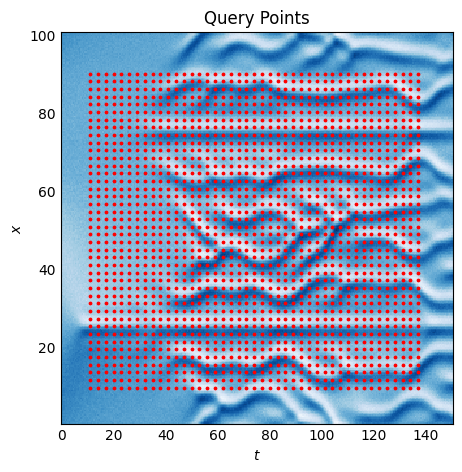

In [34]:
# Plot query points
plt.rcParams['figure.figsize'] = [4, 4]
fig, ax = plt.subplots()
ax.pcolormesh(T_mesh, X_mesh, U)
ax.scatter(Tk_mesh, Xk_mesh, color='red', s=3)
ax.set_title('Query Points')
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
plt.show()

#### Create Test Functions

Create **test functions** $\psi_k(x, t) = \psi(x_k-x, t_k-t)$ centered at the query points $\{(x_k, t_k)\}$.
\
**Note**: these functions are defined on a query-point-relative reference frame $(x',t') = (x_k-x, t_k-t)$.
\
\
For a derivative index $i = 0, ..., S$ and a given coordinate $x_d$ (or $t$), we call
\
$\quad \quad \left\{\partial^{(\alpha_d^i)}\phi_d\right\}_{i=0}^{S} =$ `get_test_fcns`$\left(m, \tau; \mathcal{X}, \alpha\right)$
\
to get each relevant derivative of the $d^{\rm{th}}$ component of $\psi = \phi_1 \cdots \phi_n\phi_t$.


---


The separable 'mother' test function $\psi$ is given, e.g. in (1+1) dimensions, by $\psi(x,t) = \phi_x(x) \phi_t(t)$.
\
Each $\phi_d$ is similar to a Bernstein polynomial, being defined for $x$ or $t \in (a,b)$ by:
\begin{align*}
  \phi_d(\cdot) = \frac{1}{p^p q^q}\left( \frac{p+q}{b-a} \right)^{p+q} \Big[ (x-a)^p (b-\cdot)^p \Big] .
\end{align*} We can either learn the parameters $(a,b,p,q)$ or use known values (a usual choice is $q:=p$ and $a:=-b$, with $b:=m\Delta$).


---


To illustrate the computational process used below in (1+1) dimensions, we have: \begin{align*}
  \mathcal{D}^i \psi := \partial^{\alpha^i} \psi = \left(\partial_x^{(\alpha_1^i)}\phi_x\right) \cdot \left(\partial_t^{(\alpha_t^i)}\phi_t\right),
\end{align*} and, e.g. for $x$ being the $d=1$ coordinate, we can compute \begin{align*}
  \phi_x^{(\alpha_1^i)}(x') = \left(\frac{1}{m_x\Delta{x}}\right)^{(\alpha_1^i)}
  \ \bar{\phi}_{p_x}^{(\alpha_1^i)} \left(\frac{x'}{m_x\Delta{x}}\right),
\end{align*} where for $x \in (-1,1)$, \begin{align*}
  \bar{\phi}_p(\cdot) := \left(1 - {(\cdot)}^2\right)^p.
\end{align*} The original MatLab code picks unspecified $p$ values by setting \begin{align*}
  p = \max\left\{\bar{\alpha}+1, \ \left\lceil\frac{\ln(\tau)}{\ln\left( \frac{2m-1}{m^2} \right)}\right\rceil\right\} .
\end{align*}

In [11]:
# Calculate symbolic derivatives
def D_phi_bar(x, p, D):
  # Dth derivative at degree p
  x_sym = sp.Symbol('x')
  phi_bar = (1 - x_sym**2)**p
  D_phi = sp.diff(phi_bar, x_sym, D)

  # Evaluate at point x
  if abs(x) < 1:
    return float(D_phi.subs(x_sym, x))
  elif abs(x) >= 1:
    return 0.0

# Allow for a vector of input data
def D_phi_vec(x, p, D):
  vec = np.vectorize(D_phi_bar)
  return torch.from_numpy(vec(x, p, D))

In [12]:
def get_test_fcns(m, tau, x_or_t, alpha, d, **kwargs):
  # kwargs = {dx_or_dt, p, scales}
  #----------------------------------------
  # dx_or_dt = space or time discretization
  # p = known degree for test fcns
  # scales = scale factors (yu, yx, yt)
  #----------------------------------------

  # Number of points in x_d coordinate
  N = x_or_t.shape[0]

  # Check if dx (or dt) were provided
  if 'dx_or_dt' in kwargs:
    dx_or_dt = kwargs['dx_or_dt']
  else:
    dx_or_dt = (x_or_t[1]-x_or_t[0]).item()

  # Check if scaling factors were provided
  if 'scales' in kwargs:
    (yu, yx, yt) = kwargs['scales']
    dx_or_dt = (yu,yx,yt)[d] * dx_or_dt

  # Check size compatibility of support m
  if (m > (N-1)/2) or (m <= 1):
    raise Exception('Error: test fcn not compactly supported.')

  # Check if a known p was provided
  if 'p' in kwargs:
    p = kwargs['p']
  else:
    # Solve minimization problem for degree p
    alpha_bar = max(tuple(item[d-1] for item in alpha))
    log_tau_term = np.ceil(np.log(tau)/np.log((2*m-1)/m**2))
    p = max(log_tau_term, alpha_bar + 1)

  # Initialize grid of discretized test fcn values
  test_fcns = torch.zeros(len(alpha), 2*m+1, dtype=x_or_t.dtype)
  n_grid = torch.arange(-1, 1.0001, 1/m, dtype=x_or_t.dtype)

  # Multi-index values (a_d^i), for i=0,...,S
  multi_index_n = tuple(item[d-1] for item in alpha)

  # Compute D^i derivative of phi_d, for i=0,...,S
  for i in range(len(alpha)):
    # Get multi-index value (a_d^i)
    num_derivs = multi_index_n[i]

    # Evaluate order-(a_d^i) derivative on n_grid
    # LIKELY A TIME-CONSUMING STEP (SPEED-UP)
    A_s = D_phi_vec(n_grid, p, num_derivs)

    # Add the rescaled D^i derivative to the grid of values
    test_fcns[i,:] += (1/((m*dx_or_dt)**num_derivs)) * A_s

  # Finally, return test function derivatives
  return test_fcns

Optionally, plot a few test function derivatives $\left\{\phi_d^{(\alpha^i_d)}\right\}$ for various derivative indices $i = 0, \dots, S$.

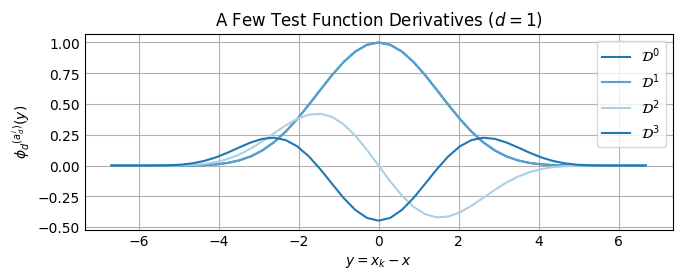

In [13]:
# Compute some example derivatives
# Space (d=1)
# Time (d=2)
d = 1
scaled = 1

# Scaled
test_fcns = get_test_fcns([mx,mt][d-1], tau, [x,t][d-1], alpha, d, dx_or_dt=[dx,dt][d-1],
                          scales=(yu**scaled,yx**scaled,yt**scaled))
y_grid = (yx**scaled)*torch.arange([-mx,-mt][d-1]*[dx,dt][d-1],
                                  [mx,mt][d-1]*[dx,dt][d-1]+0.0001, [dx,dt][d-1])

# Plot styling
plt.rcParams['figure.figsize'] = [6, 2]
fig1, ax1 = plt.subplots()

ax1.plot(y_grid, test_fcns[0,:], label = '$\mathcal{D}^0$')
ax1.plot(y_grid, test_fcns[1,:], label = '$\mathcal{D}^1$')
ax1.plot(y_grid, test_fcns[2,:], label = '$\mathcal{D}^2$')
ax1.plot(y_grid, test_fcns[3,:], label = '$\mathcal{D}^3$')

ax1.set_title(f'A Few Test Function Derivatives $(d={d})$')
ax1.set_xlabel('$y = x_k - x$')
ax1.set_ylabel('${\phi_d}^{(a_d^i)} (y)$')
plt.legend(loc = 'best')
plt.show()

del test_fcns, y_grid, d

#### Rescaling the Data

Generate **scale factors** $\gamma_u$, $\gamma_x$, and $\gamma_t$.
\
\
Data is rescaled according to $(\tilde{x}, \tilde{t}) := (\gamma_xx, \gamma_tt)$ and \begin{align*}
\tilde{u}(\tilde{x}, \tilde{t}) := \gamma_uu\left(\frac{\tilde{x}}{\gamma_x}, \frac{\tilde{t}}{\gamma_t} \right) = \gamma_uu(x,t) .
\end{align*} The official GitHub appears to use the following formula for space and time rescaling:
\begin{align*}
  \gamma_{x,t} = \frac{1}{m\Delta}
  \left[\left(
    \frac{p!}{(p - \lfloor\frac{\bar{\alpha}}{2}\rfloor)!\lceil\frac{\bar{\alpha}}{2}\rceil!}
  \right)\bar{\alpha}!\right]^{1/\bar{\alpha}} .
\end{align*}


---


**Note**: the $u$-scaling on the official GitHub is given in reciprocal form,
\begin{align*}
  \frac{1}{\gamma_u}
  \approx
  \texttt{scale_u} :=
  \left| \frac{\boldsymbol{u}}{|\boldsymbol{u}|^{(1/\bar\beta)}_{2}} \right|_{2\bar\beta}
  ^{\left(\frac{\bar\beta}{\max(\bar\beta-1,1)}\right)} ,
\end{align*} as opposed to the paper, where
\begin{align*}
  \gamma_u = \left(\frac{|\boldsymbol{u}|_2}{|\boldsymbol{u}^{\bar\beta}|_2}\right)^{1/\bar\beta} .
\end{align*} Correspondingly, in the original MatLab code, the authors use an inverted scaling matrix diagonal $\mu$, to the tune of \begin{align*}
  \mu_{(j-1)S+i} = \gamma_u^{(1-\beta_j)}
  \gamma_x^{(\alpha_{x}^0-\alpha_{x}^i)}\gamma_t^{(\alpha_{t}^0-\alpha_{t}^i)}.
\end{align*}


---


**Another note**: in the original MatLab code, the scaling matrix diagonal $\mu$ is ordered according to \begin{align*}
  \mu &\rightarrow \Big\{ (\mathcal{D}^1 f_1), \ (\mathcal{D}^1 f_2,...,\mathcal{D}^Sf_2), \ \dots,  \ (\mathcal{D}^1 f_J,...,\mathcal{D}^Sf_J) \Big\},
\end{align*} where terms corresponding to derivatives of constants (i.e., terms of the form $\mathcal{D}^if_1$ for $i\geq2$) are excluded. This is in contrast to the paper, where terms are ordering accord to \begin{align*}
  \Big\{ (\mathcal{D}^1 f_1, \dots, \mathcal{D}^1f_J), \ (\mathcal{D}^2 f_2,...,\mathcal{D}^2f_J), \ \dots,  \ (\mathcal{D}^S f_2,...,\mathcal{D}^Sf_J) \Big\}.
\end{align*}

In [14]:
# Carefully compute n-choose-k with non-integer k
def my_nchoosek(n,k):
  n_factorial = scipy.special.factorial(n)
  k_factorial = scipy.special.factorial(np.ceil(k))
  nk_term = scipy.special.factorial(n-np.floor(k))
  return n_factorial / (nk_term * k_factorial)

def get_scales(fj_poly, fj, alpha, U, mx, mt, dx, dt, px, pt, **kwargs):
  # kwargs = {scales}
  #-----------------------------------
  # scales = known scales (yu, yx, yt)
  #-----------------------------------

  # Check if known scales were provided
  if 'scales' in kwargs:
    (yu, yx, yt) = kwargs['scales']
  # Otherwise, compute scales
  else:
    # Total number of coordinates
    n_coords = len(alpha[0])

    # Maximum monomial power in library
    beta_bar = max(fj_poly)

    # Find maximum spatial derivative
    alpha_bar_x = 0

    for d in range(n_coords - 1):
      max_n = max(tuple(item[d] for item in alpha))
      if max_n > alpha_bar_x:
        alpha_bar_x = max_n

    # Find maximum temporal derivative
    alpha_bar_t = max(tuple(item[n_coords - 1] for item in alpha))

    # Compute L^2 norm of U and U^beta as vectors
    U_2 = torch.linalg.norm(torch.reshape(U, (-1,))).item()
    U_beta_2 = torch.linalg.norm(torch.reshape(U**beta_bar, (-1,))).item()

    # Compute scales using ansatz given in paper
    yu = (U_2/U_beta_2)**(1/beta_bar)
    yx = (1/(mx*dx))*(my_nchoosek(px, alpha_bar_x/2)
        *scipy.special.factorial(alpha_bar_x))**(1/alpha_bar_x)
    yt = (1/(mt*dt))*(my_nchoosek(pt, alpha_bar_t/2)
        *scipy.special.factorial(alpha_bar_t))**(1/alpha_bar_t)

  # Compute scale matrix, M = diag(mu)
  mu = torch.zeros((len(alpha)-1) * len(fj), dtype=U.dtype)
  for i in range(1, len(alpha)):
    for j in range(len(fj)):

      # Exponents for yx, yt
      x_exp = 0
      for d in range(len(alpha[0])-1):
        x_exp += alpha[i][d] - alpha[0][d]
      t_exp = alpha[i][-1] - alpha[0][-1]

      # Check if fj is trig or polynomial
      if j > (len(fj_poly)-1):
        # Trig term, set beta_j = 0
        mu[(i-1)*len(fj) + j] = (yu)*(yx**x_exp)*(yt**t_exp)
      elif j <= (len(fj_poly)-1):
        # Polynomial term
        mu[(i-1)*len(fj) + j] = (yu**(1-fj[j]))*(yx**x_exp)*(yt**t_exp)

  # Make M = diag(mu)
  M = torch.diag(mu)

  # Return scales and scale matrix
  return yu, yx, yt, M

# Call the function
#yu, yx, yt, M = get_scales(fj_poly,fj,alpha,U,mx,mt,dx,dt,px,pt,scales=(yu,yx,yt))
yu, yx, yt, M = get_scales(fj_poly,fj,alpha,U,mx,mt,dx,dt,px,pt)
print(yu, yx, yt)

0.5221529198490495 0.7361470375204827 0.09090909090909091


Compute test functions for later use.
\
**Speed-up**: don't really need to store repeated test function derivatives.

In [15]:
# Compute separable test functions
# Space (unscaled and rescaled)
Dphi_x_list = get_test_fcns(mx, tau, x, alpha, 1, dx_or_dt = dx, p=px)
Dphi_xs_list = get_test_fcns(mx,tau,x,alpha,1,dx_or_dt=dx,p=px,scales=(yu,yx,yt))

# Time (unscaled and rescaled)
Dphi_t_list = get_test_fcns(mt, tau, t, alpha, 2, dx_or_dt = dt, p=pt)
Dphi_ts_list = get_test_fcns(mt,tau,t,alpha,2,dx_or_dt=dt,p=pt,scales=(yu,yx,yt))

#### Create the LHS

Compute the **LHS** of the convolutional weak form over the query points: \begin{align*}
  b_k = \left(\Psi^0 \star u\right)(x_k, t_k),
  \quad \text{where} \quad
  \Psi^0 := \mathcal{D}^0 \psi(Y) \cdot \left[\Delta{x}^{(n-1)}\Delta{t}\right],
\end{align*} which is the discrete anlogue of
\begin{align*}
  \left(\Psi^0 \star u\right)(x_k, t_k)
  \ &≈ \
  \int_{0}^{T}\!\!\!\!\!\int_{\Omega} \mathcal{D}^0\psi(x_k - x, t_k -t ) u(x,t) \ dx \ dt
  \\
  \ &= \
  \int_{0}^{T} \mathcal{D}^0\phi_t(t_k -t ) \left(\int_{\Omega} \phi_x(x_k-x) u(x,t) \ dx \right) \ dt
  \\
  \ &= \
  \int_{0}^{T} \mathcal{D}^0\phi_t(t_k -t ) \left( \phi_x \star u^t \right)(x_k) \ dt
  \\
  \ &= \
  \left( \mathcal{D}^0\phi_t \star \left( \phi_x \star u^t \right) \right)(x_k, t_k) \ .
\end{align*} By the convolution theorem, we then have: \begin{align*}
  \left(\Psi^0 \star u\right)(x_k, t_k)
  \ &≈ \
  \mathcal{F}^{-1} \Big\{
    \mathcal{F}\left[ \mathcal{D}^0\phi_t \right]
    \cdot
    \mathcal{F}\left[ \phi_x \right] \cdot \mathcal{F}\left[ u^t \right]
  \Big\} (x_k, t_k) .
\end{align*}
\
Below, we use `scipy.signal.convolve` function to compute the relevant convolutions. It's fast and uses automatic [FFT](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve.html) speedups.


---


**Note**: when using rescaled coordinates, one must be careful to make the replacement $(b, \Psi, u, x, t) \ \mapsto \ (\tilde{b}, \tilde{\Psi}, \tilde{u}, \tilde{x}, \tilde{t})$.

In [16]:
# Grab separable test functions
# Space
D0phi_x = Dphi_x_list[0,:]
D0phi_xs = Dphi_xs_list[0,:]

# Time
D0phi_t = Dphi_t_list[0,:]
D0phi_ts = Dphi_ts_list[0,:]

# Compute the LHS vector b
def create_b(U, D0phi_x, D0phi_t, dx, dt, mask_rows, mask_cols, **kwargs):
  # kwargs = {scales}
  #------------------------------------
  # scales = scale factors (yu, yx, yt)
  #------------------------------------

  # Check if scaling factors were provided
  if 'scales' in kwargs:
    (yu, yx, yt) = kwargs['scales']
    (U_, dx_, dt_) = (yu*U, yx*dx, yt*dt)
  else:
    (U_, dx_, dt_) = (U, dx, dt)

  # Temporarily convert to numpy arrays
  D0phi_x_ = D0phi_x.numpy()
  D0phi_t_ = D0phi_t.numpy()
  U_ = U_.numpy()

  # 1D spatial convolution along x-axis
  space_conv = scipy.signal.convolve(U_, D0phi_x_[:, None], mode='same')

  # 1D temporal convolution along t-axis
  time_conv = scipy.signal.convolve(space_conv, D0phi_t_[None,:], mode='same')

  # Convert back to pytorch tensor
  b_matrix = dx_*dt_*(torch.from_numpy(time_conv))

  # Convert to column vector and return
  b = (b_matrix[mask_rows, mask_cols]).reshape(-1,1)
  return b

# Compute b over query points
b = create_b(U.clone(),D0phi_x.clone(),D0phi_t.clone(),dx,dt,mask_rows,mask_cols)
b_scaled = create_b(U.clone(), D0phi_xs.clone(), D0phi_ts.clone(), dx, dt,
                    mask_rows, mask_cols, scales=(yu,yx,yt))

Double-check results against [naive convolution](https://en.wikipedia.org/wiki/Multidimensional_discrete_convolution):
\begin{align*}
  \left( \Psi^0 \star u \right)[x_k, t_k]
  \ &= \
  \Delta{x}\Delta{t} \sum_{\bar{x}=x_k-m_x}^{x_k+m_x}
  \sum_{\bar{t}=t_k-m_t}^{t_k+m_t}
  \phi_x[x_k - \bar{x}] \
  \mathcal{D}^0 \phi_t[t_k - \bar{t}] \
  u[\bar{x}, \bar{t}]
  \\
  \ &= \
  \Delta{x}\Delta{t} \sum_{\bar{x}=x_k-m_x}^{x_k+m_x}
  \phi_x[x_k - \bar{x}] \
  \left[\sum_{\bar{t}=t_k-m_t}^{t_k+m_t}
  \mathcal{D}^0 \phi_t[t_k - \bar{t}] \
  u[\bar{x}, \bar{t}]\right]
\end{align*}

In [17]:
# Double-check with naive convolution at (xk, tk)
# (Provide index n = nth xk index, where xk[n] = x[mx + n*sx])
# (Provide index m = mth tk index, where tk[m] = t[mt + m*st])
# (Likewise, Uk[n,m] = U[mx + n*sx, mt + m*st])

def naive_convolution(U, D0phi_x, D0phi_t, mx, mt, n, m, dx, dt, a0):
  bk = 0
  for x_bar in range(-mx, mx+1):
    for t_bar in range(-mt, mt+1):
      U_term = U[(mx+n*sx)+x_bar,(mt+m*st)+t_bar]
      bk += (D0phi_x[mx+x_bar] * D0phi_t[mt+t_bar] * U_term)
  return ((-1)**a0)*dx*dt*bk

# Pick a sample query point X(k1,k2)
k1 = 4
k2 = 5
bk_test = naive_convolution(U, D0phi_x, D0phi_t,
                            mx, mt, k1, k2, dx, dt,sum(alpha[0]))
bk_test_scaled = naive_convolution(yu*U, D0phi_xs, D0phi_ts,
                                   mx, mt, k1, k2, yx*dx, yt*dt, sum(alpha[0]))

# Print the difference between the approaches (naive - FFT)
print(f'Unscaled = {bk_test.item()-b[k1*len(tk_indices)+k2].item()}')
print(f'Scaled = {bk_test_scaled.item()-b_scaled[k1*len(tk_indices)+k2].item()}')

del bk_test, bk_test_scaled, k1, k2

Unscaled = 4.718447854656915e-16
Scaled = 4.718447854656915e-16


Optionally, visualize the frequency spectrum of test functions.

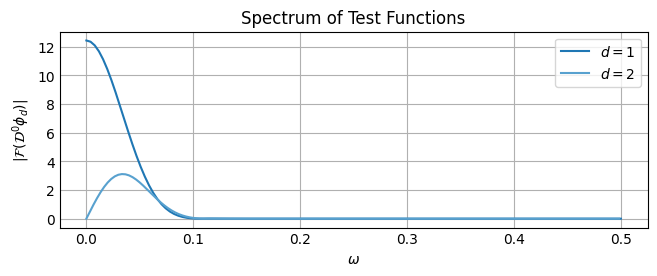

In [18]:
# Take the FFT
# Unscaled
D0phi_x_hat = torch.fft.rfft(D0phi_x, n=U.shape[0])
D0phi_t_hat = torch.fft.rfft(D0phi_t, n=U.shape[1])

# Scaled
#D0phi_x_hat = torch.fft.rfft(D0phi_xs, n=U.shape[0])
#D0phi_t_hat = torch.fft.rfft(D0phi_ts, n=U.shape[1])

# Plot the (symmetric) test fcn spectrum
fig, ax = plt.subplots()
plt.rcParams['figure.figsize'] = [6, 2]
ax.plot(torch.fft.rfftfreq(U.shape[0]), abs(D0phi_x_hat), label='$d=1$')
ax.plot(torch.fft.rfftfreq(U.shape[1]), abs(D0phi_t_hat), label='$d=2$')
ax.set_title('Spectrum of Test Functions')
ax.set_xlabel('$\omega$')
ax.set_ylabel('$|\mathcal{F}(\mathcal{D}^0\phi_d)|$')
plt.legend(loc = 'best')
plt.show()

#### Create the Model Library

Compute the **model library** $L$ over the query points: \begin{align*}
  L_{k,(i-1)J+j} = \left(\Psi^i \star f_j(u)\right)(x_k, t_k),
  \quad \text{where} \quad
  \Psi^i := \mathcal{D}^i \psi(Y) \cdot \left[\Delta{x}^{(n-1)}\Delta{t}\right].
\end{align*}
\
Much like before, this convolution can be written in the form: \begin{align*}
  \left(\Psi^i \star f_j(u)\right)(x_k, t_k)
  =
  \left( \partial_t^{(\alpha^i_t)} \phi_t \star \left( \partial_x^{(\alpha^i_x)} \phi_x \star f_j(u^t) \right) \right)(x_k, t_k),
  \quad \text{where} \quad \mathcal{D}^i = \frac{\partial^{|\alpha^i|}}{\partial_t^{(\alpha^i_t)} \partial_x^{(\alpha^i_x)}} \ .
\end{align*}
\
The discrete convolution looks something like the one above, \begin{align*}
  \left( \Psi^i \star f_j(u) \right)[x_k, t_k]
  \ &= \
  \Delta{x}\Delta{t} \sum_{\bar{x}=x_k-m_x}^{x_k+m_x}
  \sum_{\bar{t}=t_k-m_t}^{t_k+m_t}
  \partial_x^{(\alpha^i_x)}\phi_x[x_k - \bar{x}] \
  \partial_t^{(\alpha^i_t)} \phi_t[t_k - \bar{t}] \
  f_j(u[\bar{x}, \bar{t}])
  \\
  \ &= \
  \Delta{x}\Delta{t} \sum_{\bar{x}=x_k-m_x}^{x_k+m_x}
  \partial_x^{(\alpha^i_x)}\phi_x[x_k - \bar{x}] \
  \left[\sum_{\bar{t}=t_k-m_t}^{t_k+m_t}
  \partial_t^{(\alpha^i_t)} \phi_t[t_k - \bar{t}] \
  f_j\left(u[\bar{x}, \bar{t}]\right)\right] .
\end{align*}


---


**Note**: when using rescaled variables, we must again be careful to make the replacement $(f_j, \Psi, u, x, t) \ \mapsto \ (\tilde{f_j}, \tilde{\Psi}, \tilde{u}, \tilde{x}, \tilde{t})$.


---


**Another note**: when $f_j$ is a monomial with power $\beta_j$ (that is, $f_j(u)=u^{\beta_j}$), it is homogeneous of power $\beta_j$ and can be sneakily rescaled as follows: \begin{align*}
  \tilde{f_j}(\tilde{u})
  :=
  f_j(\tilde{u})
  =
  f_j(\gamma_uu)
  = {\gamma_u^{\beta_j}} f_j(u) \ .
\end{align*}

In [19]:
# Evaluate library functions {fj} on data
# (Note: j is 1-indexed here, so input j=1,...,J)

def evaluate_fj(fj_name, fj_list, j, U, **kwargs):
  # kwargs = {scales}
  #----------------------------------
  # scales = scale factors (yu,yx,tx)
  #----------------------------------

  # Check if scaling factors were provided
  if 'scales' in kwargs:
    (yu,yx,yt) = kwargs['scales']
    U_ = yu * U
  else:
    U_ = U

  # Monomial function for a single field u(x,t)
  if fj_name == 'fj_poly':
    # Evaluate jth monomial
    fj_of_U_ = U_**fj_list[j-1]

  # Sinus/cosinus for a single field u(x,t)
  elif fj_name == 'fj_poly':
    # Evaluate jth frequency [0], phase [1]
    fj_of_U_ = np.sin(fj_list[j-1][0]*U_ + fj_trig[j-1][1])

  # In case the given function is not defined
  else:
    raise Exception(f'{fj_name} was not found.')

  # Return fj(U)
  return fj_of_U_

Compute the $((i-1)J+j)^{\rm{th}}$ column of the model library $L$, corresponding to the derivative $\mathcal{D}^i$ and the function $f_j$.

In [20]:
# Compute column of model library
# (Evaluated for specific i,j)

def get_library_column(fj_of_U, Diphi_x, Diphi_t, dx, dt, mask_rows, mask_cols, **kwargs):
  # kwargs = {scales}
  #------------------------------------
  # scales = scale factors (yu, yx, yt)
  #------------------------------------

  # Check if scaling factors were provided
  if 'scales' in kwargs:
    (yu, yx, yt) = kwargs['scales']
    (dx_, dt_) = (yx*dx, yt*dt)
  else:
    (dx_, dt_) = (dx, dt)

  # Convert to numpy arrays
  Diphi_x_ = Diphi_x.numpy()
  Diphi_t_ = Diphi_t.numpy()
  fj_of_U_ = fj_of_U.numpy()

  # 1D spatial convolution along x-axis
  space_conv = scipy.signal.convolve(fj_of_U_, Diphi_x_[:, None], mode='same')

  # 1D temporal convolution along t-axis
  time_conv = scipy.signal.convolve(space_conv, Diphi_t_[None,:], mode='same')

  # Convert back to pytorch tensor
  Lij_matrix = dx_*dt_*(torch.from_numpy(time_conv))

  # Convert to column vector over query points and return
  Lij = (Lij_matrix[mask_rows, mask_cols]).reshape(-1,1)
  return Lij

In [21]:
# Creating the entire K x SJ library matrix
K = len(xk_indices) * len(tk_indices)
J = len(fj)
S = len(alpha)-1

# Initialize library matrix
L = torch.zeros(K, S*J, dtype=U.dtype)
L_scaled = torch.zeros(K, S*J, dtype=U.dtype)

# Loop over all functions {fj}
for j in range(1,J+1):

  # Compute fj(U)
  fj_name = fj_names[j-1]
  fj_of_U = evaluate_fj(fj_name, fj, j, U.clone())
  fj_of_U_scaled = evaluate_fj(fj_name, fj, j, U.clone(), scales=(yu,yx,yt))

  # Loop over all derivatives D^i
  for i in range(1,S+1):

    # Get the corresponding test fcns
    # Unscaled
    Diphi_x = Dphi_x_list[i,:]
    Diphi_t = Dphi_t_list[i,:]

    # Scaled
    Diphi_xs = Dphi_xs_list[i,:]
    Diphi_ts = Dphi_ts_list[i,:]

    # Compute corresponding library column
    # Unscaled
    Lij = get_library_column(fj_of_U.clone(), Diphi_x.clone(), Diphi_t.clone(),
                             dx, dt, mask_rows, mask_cols)
    L[:,(i-1)*J+j-1] = Lij[:,0]

    # Scaled
    Lij_scaled = get_library_column(fj_of_U_scaled.clone(), Diphi_xs.clone(), Diphi_ts.clone(),
                                    dx, dt, mask_rows, mask_cols, scales=(yu,yx,yt))
    L_scaled[:,(i-1)*J+j-1] = Lij_scaled[:,0]

# Optionally, remove non-trivial derivatives of constant terms
# (These are the D^i[f_1] for i=2,...,S term)
cols_to_remove = [len(fj)*c for c in range(1,len(alpha)-1)]
RHS_names = [term for col, term in enumerate(RHS_names) if col not in cols_to_remove]

# Column removal mask
Lib_mask = torch.ones(L.shape[1], dtype=torch.bool)
Lib_mask[cols_to_remove] = False
L = L[:, Lib_mask]
L_scaled = L_scaled[:, Lib_mask]

# Remove irrelevant scale matrix columns as well
M = torch.diag(M[Lib_mask,Lib_mask])

del fj_name, Lij, Lij_scaled
del Diphi_x, Diphi_t, fj_of_U
del Diphi_xs, Diphi_ts, fj_of_U_scaled

Checking the condition numbers of the library matrices, $\kappa(L)$ and $\kappa(\tilde{L})$.

In [22]:
# Cond(L)
print(L.shape, L.dtype)
print(torch.linalg.cond(L,p=2))

# Cond(L_scaled)
print(L_scaled.shape, L_scaled.dtype)
print(torch.linalg.cond(L_scaled,p=2))

torch.Size([1806, 43]) torch.float64
tensor(24837.7924, dtype=torch.float64)
torch.Size([1806, 43]) torch.float64
tensor(2261.1387, dtype=torch.float64)


Optionally (like above), test a column computation against naive convolution.

In [23]:
# Grab a sample separable test function
i = 2
# Space
Diphi_x = Dphi_x_list[i,:]
Diphi_xs = Dphi_xs_list[i,:]
# Time
Diphi_t = Dphi_t_list[i,:]
Diphi_ts = Dphi_ts_list[i,:]

# Pick a sample {fj} function
j = 4
fj_eg = evaluate_fj('fj_poly', fj_poly, j, U.clone())
fj_eg_scaled = evaluate_fj('fj_poly', fj_poly, j, U.clone(), scales=(yu,yx,yt))

# Pick a sample query point (xk,tk)
k1 = 4
k2 = 5

# Unscaled
Lij_test = naive_convolution(fj_eg, Diphi_x.clone(), Diphi_t.clone(),
                             mx, mt, k1, k2, dx, dt, sum(alpha[i]))
Lij = get_library_column(fj_eg, Diphi_x.clone(), Diphi_t.clone(),
                         dx, dt, mask_rows, mask_cols)

# Scaled
Lij_test_scaled = naive_convolution(fj_eg_scaled, Diphi_xs.clone(), Diphi_ts.clone(),
                                    mx, mt, k1, k2, yx*dx, yt*dt, sum(alpha[i]))
Lij_scaled = get_library_column(fj_eg_scaled, Diphi_xs.clone(), Diphi_ts.clone(),
                                dx, dt, mask_rows, mask_cols, scales=(yu,yx,yt))

# Print the difference between the approaches (naive - FFT)
print(f'Unscaled = {Lij_test.item()-Lij[k1*len(tk_indices)+k2].item()}')
print(f'Scaled = {Lij_test_scaled.item()-Lij_scaled[k1*len(tk_indices)+k2].item()}')

del Lij, Lij_test, i, j, k1, k2
del Diphi_x, Diphi_t, fj_eg

Unscaled = 7.327471962526033e-15
Scaled = 1.0668549377257364e-16


#### MSTLS Optimization

**MSTLS** = **M**odified, **S**equential-**T**hresholding **L**east **S**quares.
\
\
This is an optimization algorithm for solving the linear problem $b = Lw$, returning an optimal, sparse weight vector $w^{\star}$ and threshold $\lambda^{\star}$.
\
There are two sub-algorithms involved:
\
\
$\quad \big(w^{\lambda}, \mathcal{L}(\lambda)\big) = $ `MSTLS_iterate`$(L, b; \mathcal{L}, \lambda), \ $
solution for a given threshold $\lambda$
\
\
$\quad \quad \ (w^{\star}, \lambda^{\star}) = $ `MSTLS`$(L, b; \mathcal{L}, \boldsymbol{\lambda}), \ $
optimal solution over a range of thresholds $\boldsymbol{\lambda}$
\
\
We'll use a threshold search space $\boldsymbol{\lambda}$ similar to the one given in the paper: \begin{align*}
  \boldsymbol{\lambda} =
  \left\{ 10^{-4+j\frac{4}{49}} : j=0,1,...,49 \right\} .
\end{align*}
\
The loss function $\mathcal{L}$ is regularized to promote sparsity, being defined as \begin{align*}
  \mathcal{L}(\lambda) = \frac{\left|L(w^{\lambda} - w^{LS})\right|_2}{|Lw^{LS}|_2}
  + \underbrace{\big(\text{% of nonzero $w_i$}\big)}_{\mathcal{L}_{\text{reg}}(\lambda) \ \ \text{is} \ \ |w^{\lambda}|_0},
\end{align*} where $w^{LS}$ is the least squares solution (see PyTorch [LS documentation](https://pytorch.org/docs/stable/generated/torch.linalg.lstsq.html)).


---


**Note**: here, we interpret the expression "$\text{supp}(w) \subset \mathcal{I}^l$" given in eq $(4.6)$ of the paper as really meaning "$\text{supp}(w) \subseteq \mathcal{I}^l$".

In [24]:
# Option to pass w_LS as kwarg to save compute time
w_LS = torch.linalg.lstsq(L, b, driver='gelsd').solution
ws_LS = torch.linalg.lstsq(L_scaled, b_scaled, driver='gelsd').solution

# Define threshold search space
# (Note: lambas should be listed in ascending order for MSTLS)
lambdas = 10**((4/49)*torch.arange(0,50)-4)

# Computes loss for a given candidate threshold
def loss(w_lambda, w_LS, L):
  # Least squares term
  LS_num = torch.linalg.norm(torch.matmul(L, w_lambda-w_LS)).item()
  LS_denom = torch.linalg.norm(torch.matmul(L, w_LS)).item()
  LS_term = LS_num / LS_denom

  # Zero norm term
  zero_norm = sum(w_lambda != 0).item()/w_lambda.shape[0]

  # Return total loss(lambda_n)
  loss_n = LS_term + zero_norm
  return loss_n

In [25]:
# MSTLS inner loop
def MSTLS_iterate(L, b, lambda_n, **kwargs):
  # kwargs = {w_LS, M, max_its}
  #----------------------------------------
  # w_LS = precomputed LS solution
  # M = scale matrix
  # max_its = maximum number of iterations
  #----------------------------------------

  if 'max_its' in kwargs:
    max_its = kwargs['max_its']
  else:
    max_its = L.shape[1]
  if 'M' in kwargs:
      M = kwargs['M']

  # Check if precomputed LS solution exists
  if 'w_LS' in kwargs:
    w_LS_ = kwargs['w_LS']
  # Otherwise, compute it
  else:
    w_LS_ = torch.linalg.lstsq(L, b, driver='gelsd').solution

  # Undo scaling if necessary
  if 'M' in kwargs:
    w_for_loss = w_LS_
    w_LS_ = torch.matmul(torch.diag(1/torch.diag(M)), w_LS_)

  # Compute |b|/|Li| bounds for all columns
  norm_b = torch.linalg.norm(b)
  norm_Li = torch.linalg.norm(L,dim=0)
  bounds = norm_b / norm_Li

  # Rescale the bounds if necessary
  if 'M' in kwargs:
    mu = torch.diag(M)
    bounds = bounds / mu

  # Define upper and lower bounds (lambda thresholding)
  L_bounds = lambda_n*torch.maximum(bounds,torch.ones(bounds.shape[0]))
  U_bounds = 1/lambda_n*torch.minimum(bounds,torch.ones(bounds.shape[0]))

  # Begin applying iterative thresholding on elements of weight vector
  iteration = 0
  w_n = w_LS_
  inds_old = torch.tensor([0])
  while iteration <= max_its:
    # Find in-bound and out-of-bound indices and set them to zero
    ib_inds = torch.where((abs(w_n[:,0])>=L_bounds)&(abs(w_n[:,0])<=U_bounds))[0]
    oob_inds = torch.where((abs(w_n[:,0])<L_bounds)|(abs(w_n[:,0])>U_bounds))[0]

    # Check stopping condition
    if (torch.equal(inds_old, ib_inds)) or (ib_inds.shape[0]==0):
      break

    # Find LS solution amongst sparser, in-bound indices
    w_n[ib_inds] = torch.linalg.lstsq(L[:,ib_inds], b, driver='gelsd').solution
    # Mask oob columns of L
    w_n[oob_inds] = 0

    # Rescale sparse solution if needed
    if 'M' in kwargs:
      w_n = torch.matmul(torch.diag(1/torch.diag(M)), w_n)

    # Update loop variables
    inds_old = ib_inds
    iteration += 1
    if iteration == max_its:
      print('MSTLS reached the maximum number of iterations allowed.')

  # Evaluate the loss function on the resulting weights
  if 'M' in kwargs:
    # Loss evaluated on scaled weights
    loss_n = loss(torch.matmul(M,w_n), w_for_loss, L)
  else:
    # Loss evaluated on input weights (scaled or unscaled)
    loss_n = loss(w_n, w_LS_, L)
  return w_n, loss_n

In [26]:
# Full MSTLS optimization, minimizing loss
def MSTLS(L, b, lambdas, **kwargs):
  # kwargs = {threshold, w_LS, M, max_its}
  #----------------------------------------
  # threshold = known optimal threshold
  # w_LS = precomputed LS solution
  # M = scale matrix (according to paper)
  # max_its = maximum number of iterations
  #----------------------------------------

  if 'max_its' in kwargs:
    max_its = kwargs['max_its']
  else:
    max_its = L.shape[1]
  if 'M' in kwargs:
    M = kwargs['M']

  # If needed, cast L,b to common data type
  if b.dtype != L.dtype:
    b.to(torch.float64) #LHS
    L.to(torch.float64) #RHS

  # Check if precomputed LS solution exists
  if 'w_LS' in kwargs:
    w_LS_ = kwargs['w_LS']
  # Otherwise, compute w_LS
  else:
    w_LS_ = torch.linalg.lstsq(L,b, driver='gelsd').solution

  # Check if known optimal threshold was provided
  if 'threshold' in kwargs:
    lambda_star = kwargs['threshold']

  # Otherwise, iterate to find lambda_star
  else:
    loss_history = []
    for lambda_n in lambdas:
      # Compute candidate weights and evaluate loss
      if 'M' in kwargs:
        w_n,loss_n = MSTLS_iterate(L,b,lambda_n.item(),w_LS=w_LS_,M=M,max_its=max_its)
      else:
        w_n,loss_n = MSTLS_iterate(L,b,lambda_n.item(),w_LS=w_LS_,max_its=max_its)
      loss_history.append(loss_n)

    # Find optimal candidate threshold
    # (Automatically finds smallest minimzer, if not unique)
    ind_star = loss_history.index(min(loss_history))
    lambda_star_ = lambdas[ind_star].item()

  # Use the optimal threshold to compute the final sparse weights
  if 'M' in kwargs:
    w_star_,loss_star_ = MSTLS_iterate(L,b,lambda_star_,w_LS=w_LS_,M=M,max_its=max_its)
  else:
    w_star_,loss_star_ = MSTLS_iterate(L, b, lambda_star_, w_LS=w_LS_, max_its=max_its)
  return w_star_, lambda_star_, loss_star_

Print the results!

In [27]:
# Compute optimal sparse weights for entire catalogue of thresholds
w, thresh, loss_val = MSTLS(L_scaled, b_scaled, lambdas, w_LS=ws_LS.clone(), M=M)

# Print results
print(f'Optimal threshold = {thresh}\nOptimal loss = {loss_val}')
#print(w)

# Get discovered PDE model as a string
def get_model(w, LHS_names, RHS_names):
  # Find nonzero RHS terms
  inds = torch.nonzero(w[:,0])[:,0].tolist()
  terms_list = ['({0:.2f})'.format(w[ind,0].item())+RHS_names[ind] for ind in inds]
  model = ' + '.join(terms_list)

  # Add to evolution operator
  model = LHS_names + ' = ' + model
  return model

pde = get_model(w, LHS_names, RHS_names)
print(f'Discovered model: {pde}')

Optimal threshold = 0.005179476458579302
Optimal loss = 0.083817130935806
Discovered model: u_t = (-0.50)(u^2)_x + (-1.00)(u^1)_xx + (-1.00)(u^1)_xxxx


The variable `pde` stores the discovered model in symbolic form.